In [80]:
import pandas as pd
import numpy as np
import panel as pn
from pmdarima import utils, arima
import mlflow

In [82]:
mlflow.pmdarima.get_default_conda_env()

{'name': 'mlflow-env',
 'channels': ['conda-forge'],
 'dependencies': ['python=3.9.0',
  'pip<=23.2.1',
  {'pip': ['mlflow', 'pmdarima==2.0.3']}]}

# Going with the usual approach

## 1. ARIMA

In [3]:
data= pd.read_excel('Data.xlsx')

In [4]:
data[data['DATETIME'].between('01-07-2023 23:00:00','01-08-2023 23:00:00')].head(50)

,DATETIME,value
668,2023-01-07 23:00:00,3225.72
669,2023-01-07 23:15:00,3150.03
670,2023-01-07 23:30:00,2920.86
671,2023-01-07 23:45:00,2700.62
672,2023-01-08 00:00:00,2851.35
673,2023-01-08 00:15:00,2840.63
674,2023-01-08 00:30:00,2820.58
675,2023-01-08 00:45:00,2771.06
676,2023-01-08 01:00:00,2768.63
677,2023-01-08 01:15:00,2768.53


In [5]:
data

,DATETIME,value
0,2023-01-01 00:00:00,2890.56
1,2023-01-01 00:15:00,2771.61
2,2023-01-01 00:30:00,2750.58
3,2023-01-01 00:45:00,2543.42
4,2023-01-01 01:00:00,2543.25
...,...,...
21115,2023-08-08 22:45:00,10000.00
21116,2023-08-08 23:00:00,10000.00
21117,2023-08-08 23:15:00,10000.00
21118,2023-08-08 23:30:00,10000.00


In [6]:
import plotly.graph_objects as go
# Add traces for first subplot
trace = go.Scatter(x=data['DATETIME'], y=data['value'], mode='lines+markers', name='timeseries')
fig = go.Figure(data=[trace])
# Layout details
fig.update_layout(
    height=1000,
    title=f"Interactive Line Plot of {'value'}",
    xaxis=dict(
            title='Datetime',  # Tilt x labels by -45 degrees
            automargin=True  # Automatically adjust margins to fit tilted labels
        ),
    yaxis_title='timeseries',
    autosize= True,
)


## Subject knowledge tells us that the range is 0-10k only. So we clip it:

In [7]:
data['value']=data['value'].clip(upper= 10000)

In [8]:
import plotly.graph_objects as go
# Add traces for first subplot
trace = go.Scatter(x=data['DATETIME'], y=data['value'], mode='lines+markers', name='timeseries')
fig = go.Figure(data=[trace])
# Layout details
fig.update_layout(
    height=1000,
    title=f"Interactive Line Plot of {'value'}",
    xaxis=dict(
            title='Datetime',  # Tilt x labels by -45 degrees
            automargin=True  # Automatically adjust margins to fit tilted labels
        ),
    yaxis_title='timeseries',
    autosize= True,
)


### Let us look at the decompositions of this pattern

In [9]:
# Isolating data with full cycles
start= '03.07.2023 03:00:00'
end= '08.08.2023 13:45:00'

In [10]:
timeseries= data[data['DATETIME'].between(start, end)]

In [11]:
timeseries


,DATETIME,value
6252,2023-03-07 03:00:00,4819.02
6253,2023-03-07 03:15:00,4819.47
6254,2023-03-07 03:30:00,4575.60
6255,2023-03-07 03:45:00,4570.74
6256,2023-03-07 04:00:00,4848.38
...,...,...
21075,2023-08-08 12:45:00,2406.34
21076,2023-08-08 13:00:00,2406.01
21077,2023-08-08 13:15:00,2380.84
21078,2023-08-08 13:30:00,2406.86


In [46]:
decomposed= arima.decompose(timeseries['value'].values, 'additive', m=96)

In [47]:
decomposed

decomposed(x=array([4819.02, 4819.47, 4575.6 , ..., 2380.84, 2406.86, 2500.85]), trend=[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 5429.054270833332, 5419.656979166666, 5410.263229166667, 5402.090104166667, 5393.7253125, 5382.465104166667, 5371.483229166666, 5357.010104166667, 5335.4515625, 5315.6821875, 5285.835625, 5246.276562499999, 5209.528645833332, 5152.232812499999, 5090.800520833333, 5034.859166666667, 4979.545833333334, 4925.9028124999995, 4873.627916666666, 4818.428124999999, 4761.6503125, 4722.884479166666, 4679.156666666666, 4642.197395833333, 4608.252083333333, 4583.571249999999, 4558.563854166666, 4533.159062499999, 4507.750729166666, 4474.427708333333, 4441.329791666666, 4413.439375, 4393.671249999999, 4377.312812499999, 4358.561145833333, 4342.209375, 4326.668333333333, 4314.6

Text(0.5, 1.0, 'Ausbeer Seasonal Decomposition')

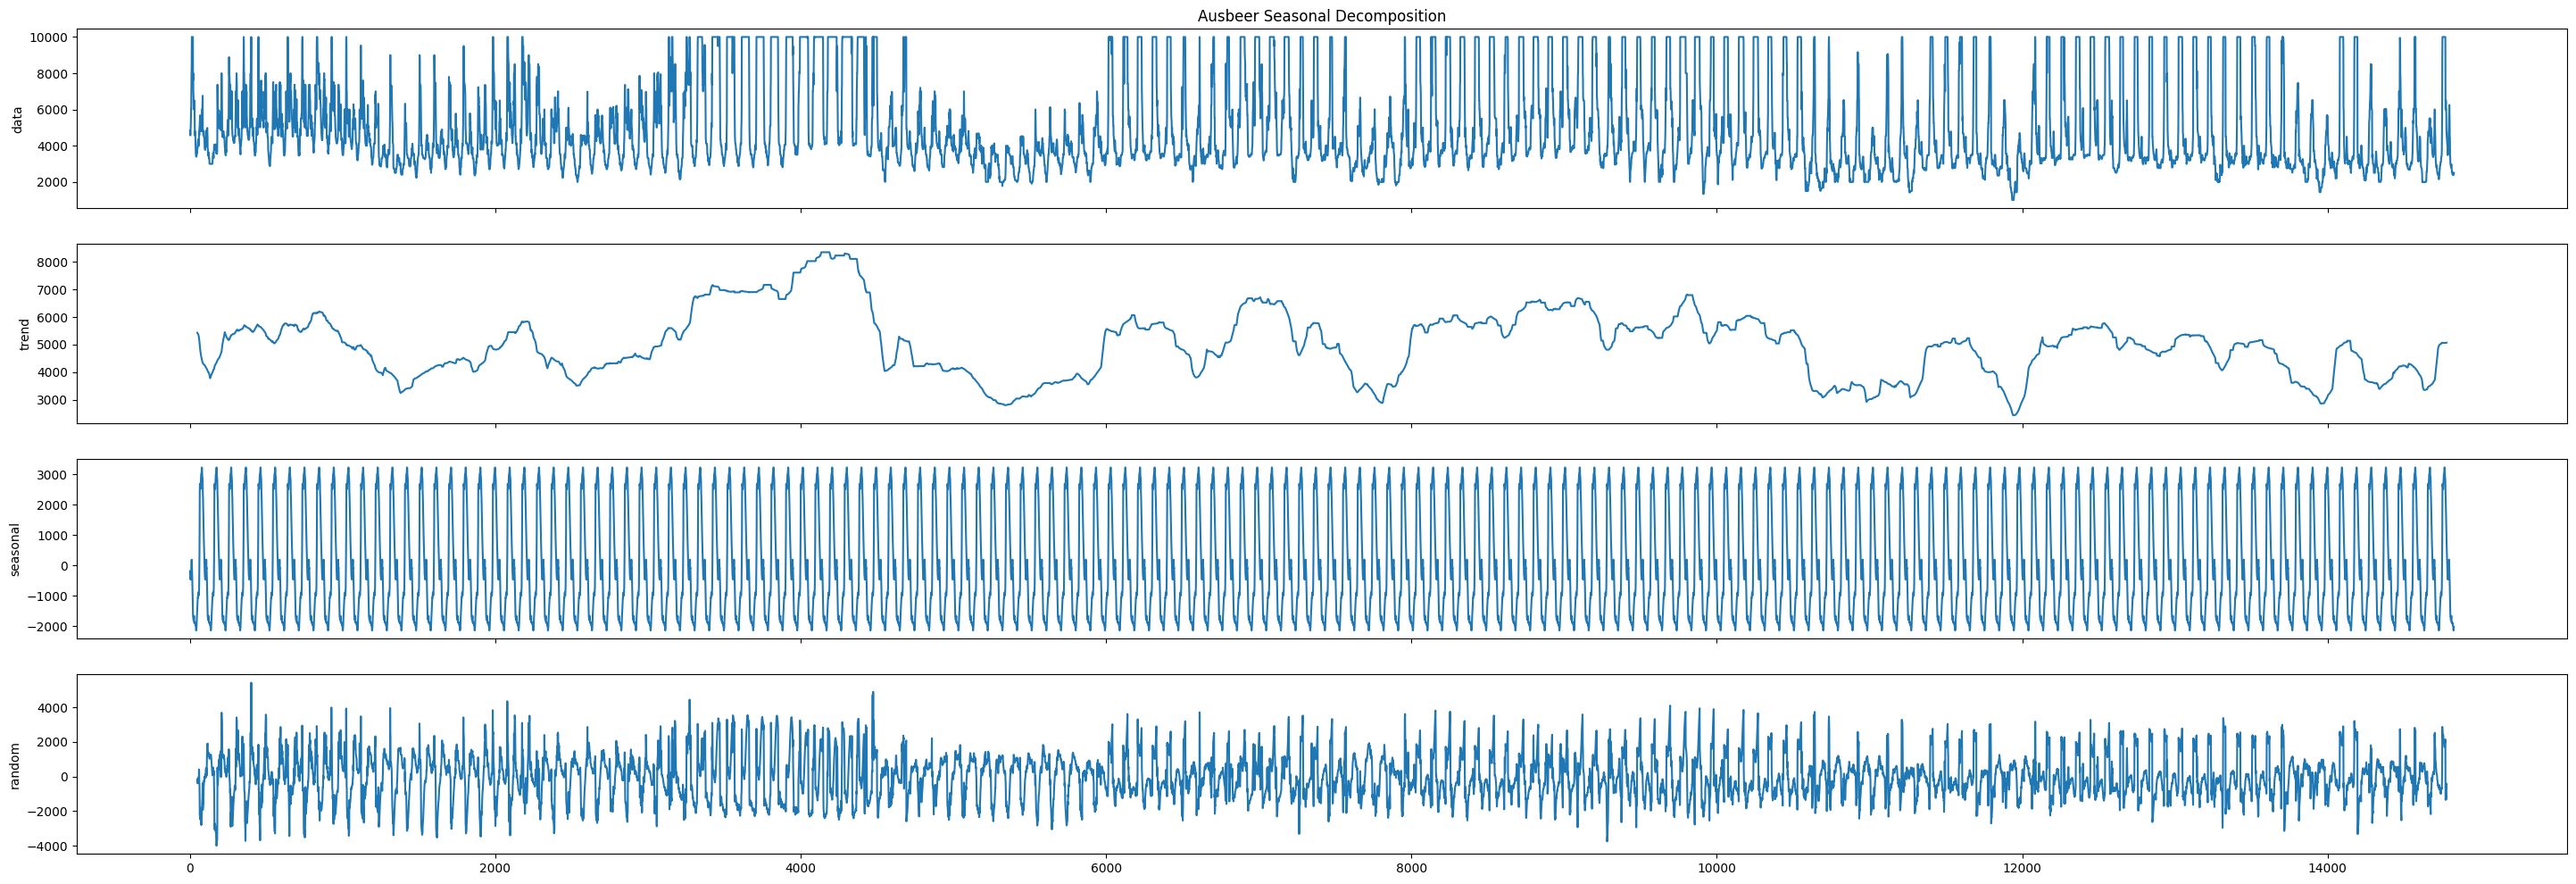

In [48]:
figure_kwargs = {'figsize': (36, 12)} 

axes = utils.decomposed_plot(decomposed, figure_kwargs=figure_kwargs,
                             show=False)
axes[0].set_title("Ausbeer Seasonal Decomposition")

## Now applying DataFeaturizer to take care of quasi-seasonal trends

In [32]:
from pmdarima import arima
from pmdarima import model_selection
from pmdarima import pipeline
from pmdarima import preprocessing
from pmdarima.datasets._base import load_date_example

<Axes: xlabel='DATETIME'>

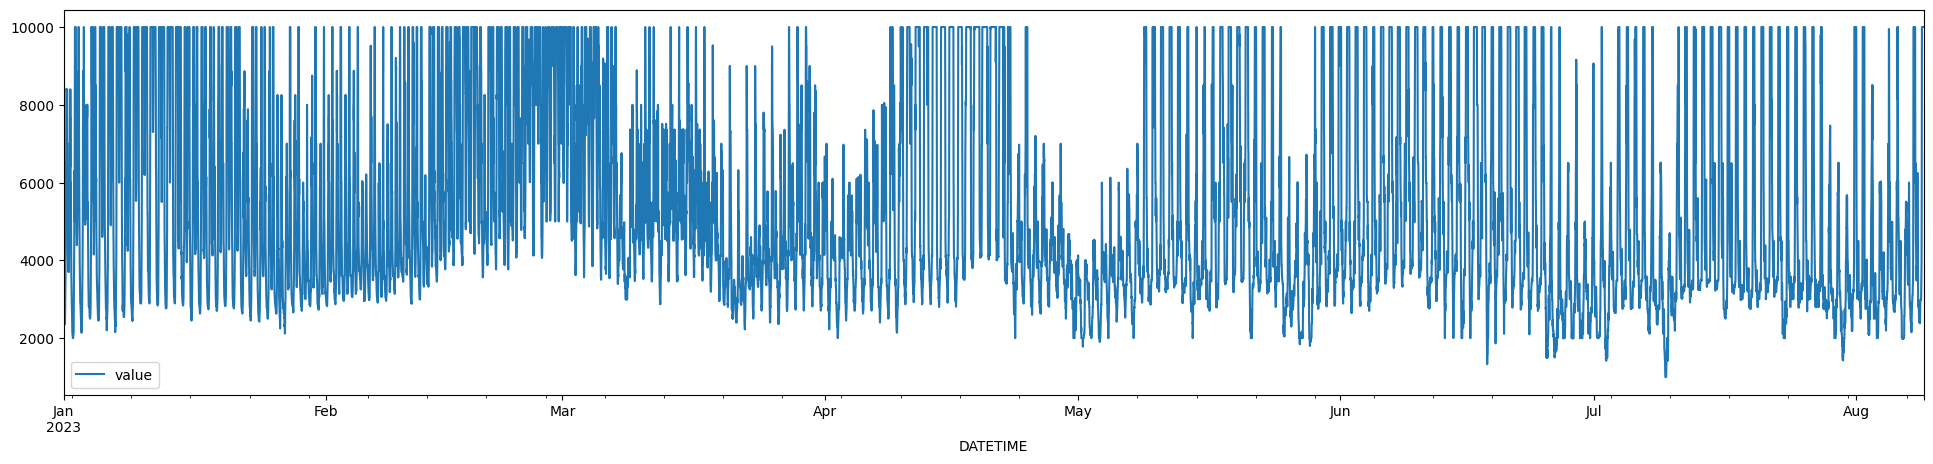

In [33]:
data.plot(figsize= (24, 5), x='DATETIME')

In [48]:
X= data[['DATETIME']]
y=data['value']

In [49]:
y_train, y_test, X_train, X_test = model_selection.train_test_split(y, X, test_size=10)

In [50]:
# Here's what the featurizer will create for us:
date_feat = preprocessing.DateFeaturizer(
    column_name="DATETIME",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)

In [51]:
n_diffs = arima.ndiffs(y_train, max_d=5)

In [52]:
n_diffs

1

In [53]:
_, X_train_feats = date_feat.fit_transform(y_train, X_train)

In [54]:
print(f"Head of generated X features:\n{repr(X_train_feats.head())}")

Head of generated X features:
   DATE-WEEKDAY-0  DATE-WEEKDAY-1  DATE-WEEKDAY-2  DATE-WEEKDAY-3  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   DATE-WEEKDAY-4  DATE-WEEKDAY-5  DATE-WEEKDAY-6  DATE-DAY-OF-MONTH  
0               0               0               1                  1  
1               0               0               1                  1  
2               0               0               1                  1  
3               0               0               1                  1  
4               0               0               1                  1  


In [55]:
X_train_feats

,DATE-WEEKDAY-0,DATE-WEEKDAY-1,DATE-WEEKDAY-2,DATE-WEEKDAY-3,DATE-WEEKDAY-4,DATE-WEEKDAY-5,DATE-WEEKDAY-6,DATE-DAY-OF-MONTH
0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...
21105,0,1,0,0,0,0,0,8
21106,0,1,0,0,0,0,0,8
21107,0,1,0,0,0,0,0,8
21108,0,1,0,0,0,0,0,8


In [56]:
pipe = pipeline.Pipeline([
    ('DATETIME', date_feat),
    ('arima', arima.AutoARIMA(d=n_diffs,
                              trace=3,
                              stepwise=True,
                              suppress_warnings=True,
                              seasonal=False))
])

In [57]:
pipe.fit(y_train, X_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=324596.793, Time=41.90 sec
First viable model found (324596.793)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=325802.524, Time=1.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=324848.975, Time=2.44 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=325022.739, Time=2.69 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=325800.537, Time=12.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=324602.777, Time=8.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=324602.785, Time=8.85 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=324593.345, Time=14.17 sec
New best model found (324593.345 < 324596.793)
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=324603.851, Time=15.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=324584.772, Time=6.14 sec
New best model found (324584.772 < 324593.345)
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=324583.242, Time=9.14 sec
New best model found (324583.242 < 324584.772)
 ARIMA(4,1,0)(0,0,0)[0] in

Pipeline(steps=[('DATETIME', DateFeaturizer(column_name='DATETIME')),
                ('arima', AutoARIMA(d=1, seasonal=False, trace=3))])

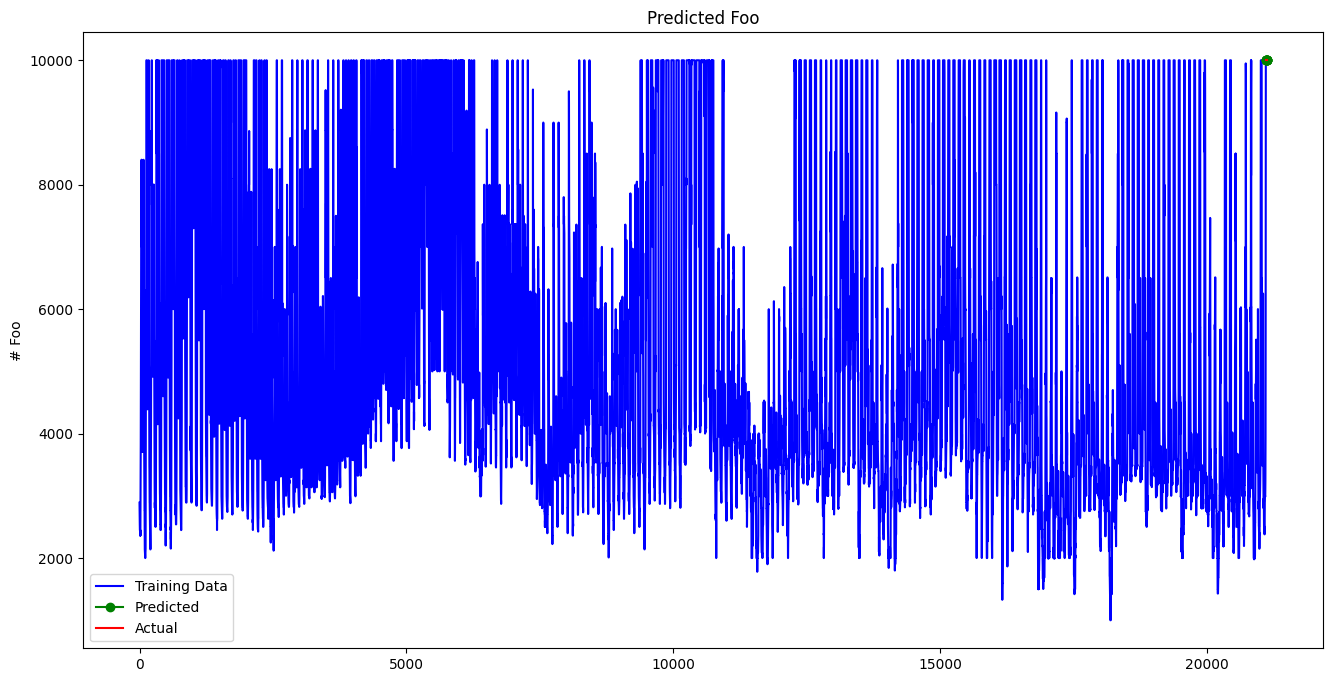

In [ ]:
import matplotlib.pyplot as plt
# Plot our forecasts
forecasts = pipe.predict(X=X_test)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)

n_train = y_train.shape[0]
x = np.arange(n_train + forecasts.shape[0])

ax.plot(x[:n_train], y_train, color='blue', label='Training Data')
ax.plot(x[n_train:], forecasts, color='green', marker='o',
        label='Predicted')
ax.plot(x[n_train:], y_test, color='red', label='Actual')
ax.legend(loc='lower left', borderaxespad=0.5)
ax.set_title('Predicted Foo')
ax.set_ylabel('# Foo')

plt.show()

In [59]:
forecasts

21110    10000.0
21111    10000.0
21112    10000.0
21113    10000.0
21114    10000.0
21115    10000.0
21116    10000.0
21117    10000.0
21118    10000.0
21119    10000.0
dtype: float64

In [60]:
y_test

21110    10000.0
21111    10000.0
21112    10000.0
21113    10000.0
21114    10000.0
21115    10000.0
21116    10000.0
21117    10000.0
21118    10000.0
21119    10000.0
Name: value, dtype: float64

<Axes: xlabel='DATETIME'>

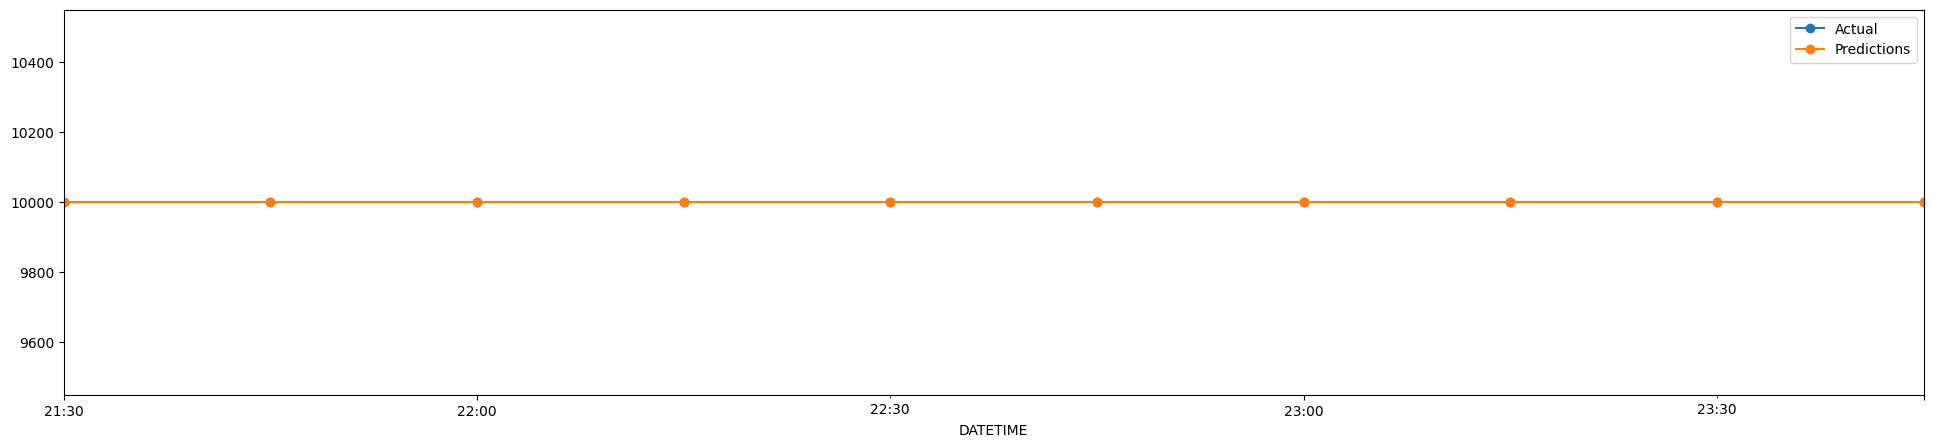

In [61]:
preds= pd.DataFrame({'Actual': y_test, 'Predictions': forecasts, 'DATETIME': X_test['DATETIME'].values})
preds.plot(x='DATETIME', y=['Actual', 'Predictions'], figsize=(24, 5), marker='o')

# Wow. This sort of gives 100 percent accuracy

#### But since all the values in the test set are constant, Id not rely on this model, as it could have been simply by fluke

We should first select only the part which is a timeseries in the dataset and then predict to check for actuaal accuuracy scores.

In [62]:
timeseries= timeseries.reset_index(drop=True)
timeseries

,DATETIME,value
0,2023-03-07 03:00:00,4819.02
1,2023-03-07 03:15:00,4819.47
2,2023-03-07 03:30:00,4575.60
3,2023-03-07 03:45:00,4570.74
4,2023-03-07 04:00:00,4848.38
...,...,...
14823,2023-08-08 12:45:00,2406.34
14824,2023-08-08 13:00:00,2406.01
14825,2023-08-08 13:15:00,2380.84
14826,2023-08-08 13:30:00,2406.86


In [63]:
X= timeseries[['DATETIME']]
y=timeseries['value']

In [64]:
y_train, y_test, X_train, X_test = model_selection.train_test_split(y, X, test_size=1)

In [65]:
# Here's what the featurizer will create for us:
date_feat = preprocessing.DateFeaturizer(
    column_name="DATETIME",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)

In [66]:
n_diffs = arima.ndiffs(y_train, max_d=5)

In [67]:
n_diffs

1

In [68]:
_, X_train_feats = date_feat.fit_transform(y_train, X_train)

In [69]:
X_train_feats

,DATE-WEEKDAY-0,DATE-WEEKDAY-1,DATE-WEEKDAY-2,DATE-WEEKDAY-3,DATE-WEEKDAY-4,DATE-WEEKDAY-5,DATE-WEEKDAY-6,DATE-DAY-OF-MONTH
0,0,1,0,0,0,0,0,7
1,0,1,0,0,0,0,0,7
2,0,1,0,0,0,0,0,7
3,0,1,0,0,0,0,0,7
4,0,1,0,0,0,0,0,7
...,...,...,...,...,...,...,...,...
14822,0,1,0,0,0,0,0,8
14823,0,1,0,0,0,0,0,8
14824,0,1,0,0,0,0,0,8
14825,0,1,0,0,0,0,0,8


In [70]:
pipe = pipeline.Pipeline([
    ('DATETIME', date_feat),
    ('arima', arima.AutoARIMA(d=n_diffs,
                              trace=3,
                              stepwise=True,
                              suppress_warnings=True,
                              seasonal=False))
])

In [71]:
pipe.fit(y_train, X_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=225060.322, Time=21.69 sec
First viable model found (225060.322)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=225903.687, Time=2.43 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=225169.253, Time=4.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=225289.287, Time=2.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=225901.698, Time=22.71 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=225058.684, Time=7.60 sec
New best model found (225058.684 < 225060.322)
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=225125.933, Time=3.71 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=225056.703, Time=5.31 sec
New best model found (225056.703 < 225058.684)
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=225058.680, Time=8.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=225072.401, Time=3.38 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=225054.704, Time=5.07 sec
New best model found (225054.704 < 225056.703)
 ARIMA(0,1,1)(0,0,0)[0]     

Pipeline(steps=[('DATETIME', DateFeaturizer(column_name='DATETIME')),
                ('arima', AutoARIMA(d=1, seasonal=False, trace=3))])

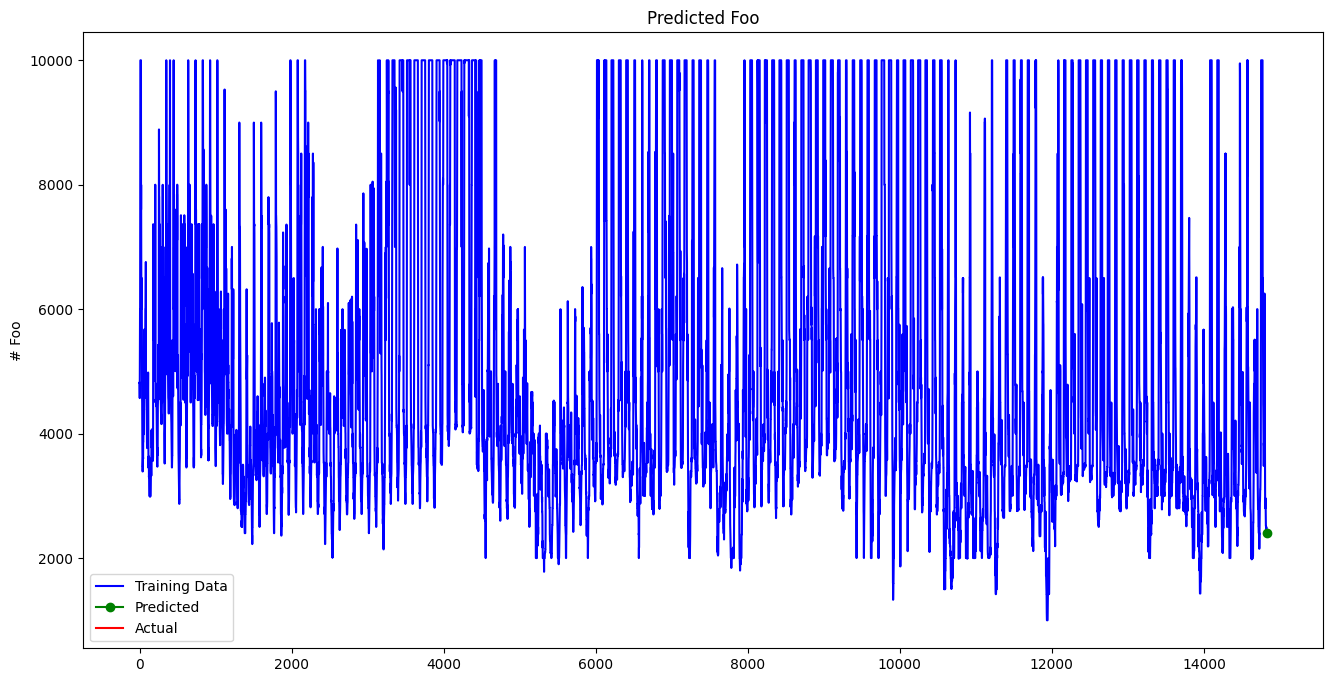

In [72]:
import matplotlib.pyplot as plt
# Plot our forecasts
forecasts = pipe.predict(X=X_test)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)

n_train = y_train.shape[0]
x = np.arange(n_train + forecasts.shape[0])

ax.plot(x[:n_train], y_train, color='blue', label='Training Data')
ax.plot(x[n_train:], forecasts, color='green', marker='o',
        label='Predicted')
ax.plot(x[n_train:], y_test, color='red', label='Actual')
ax.legend(loc='lower left', borderaxespad=0.5)
ax.set_title('Predicted Foo')
ax.set_ylabel('# Foo')

plt.show()

In [73]:
len(y_test)

1

In [74]:
y_test

14827    2500.85
Name: value, dtype: float64

In [75]:
len(forecasts)

1

In [76]:
forecasts

14827    2410.054558
dtype: float64

In [77]:
X_test['DATETIME']

14827   2023-08-08 13:45:00
Name: DATETIME, dtype: datetime64[ns]

<Axes: xlabel='DATETIME'>

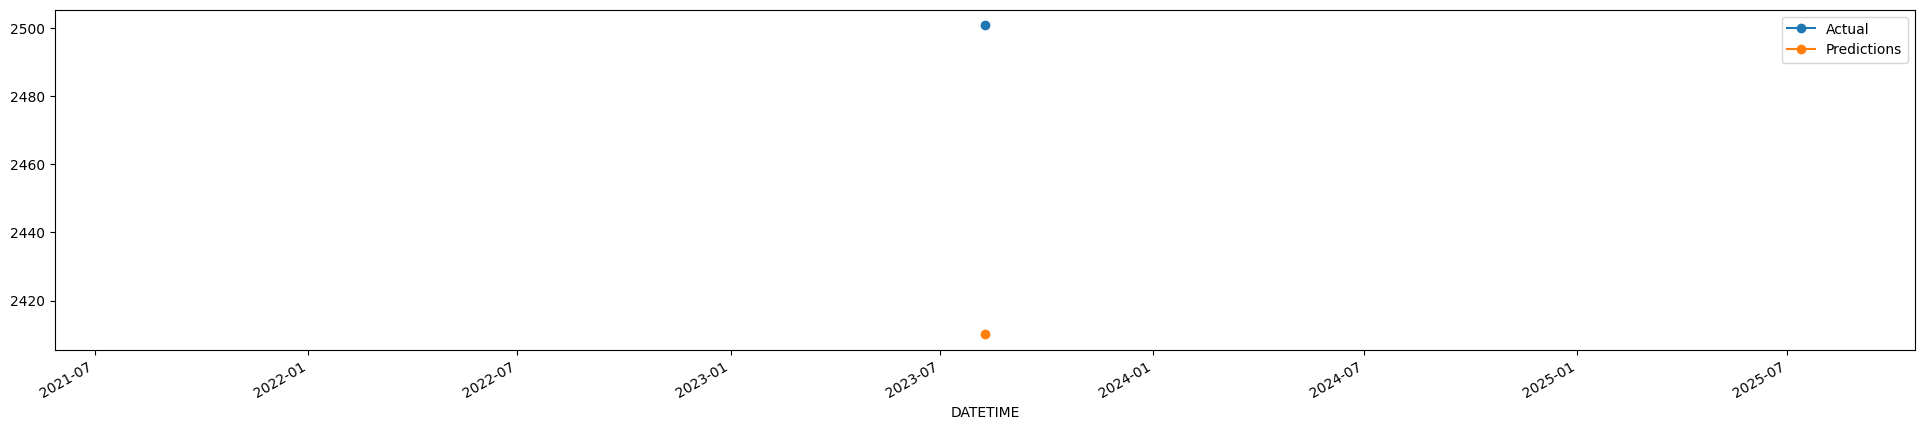

In [79]:
preds= pd.DataFrame({'Actual': y_test, 'Predictions': forecasts, 'DATETIME': X_test['DATETIME'].values})
preds.plot(x='DATETIME', y=['Actual', 'Predictions'], figsize=(24, 5), marker='o')